# HW6: dcmtrs.ipynb

In [107]:
import numpy as np # numerical library
import matplotlib.pyplot as plt # plotting library
%config InlineBackend.figure_format='retina' # high-res plots
import control.matlab as ctm # matlab layer for control systems library
import control as ct # use regular control library for a few things 
ct.set_defaults('statesp', latex_repr_type='separate') # ABCD matrices

## plant model
The A and B matrices for a state equation of the dynamics
of the DC Motors System in the University of Washington's
Control Systems Laboratory are below. 

The state vector is taken to be
 `[i1  i2  theta1  omega1  theta2  omega2].T`

the input is vector taken to be

`[e1  e2].T`

where

`i1` = Current of drive motor (A)

`i2` = Current of the load motor (A)

`theta1` = Angular position of shaft 1 (rad)

`omega1` = Angular velocity of shaft 1 (rad/sec)

`theta2` = Angular position of shaft 2 (rad)

`omega2` = Angular velocity of shaft 2 (rad/sec)

`e1` = Drive motor amplifier input voltage

`e2` = Load motor amplifier input voltage

In [108]:
# Drive motor and drive motor amplifier parameters
K1 = 99e-3     # Motor constant (V/(rad/sec))
R1 = 2.13      # Armature resistance (ohms)
Dm1 = 1.27e-4  # Motor damping constant (N*m/(rad/sec))
L1 = 0.686e-3  # Armature inductance (H)
Jm1 = 26.9e-6  # Motor inertia (kg*m**2)
Ka1 = 32.2     # Gain of amplifier gain for drive motor (V/V)
Ra1 = 0.2      # Resistance of amplifier for drive motor (ohms)

# Load motor and load motor amplifier parameters
K2 = 62e-3     # Motor constant (V/(rad/sec))
R2 = 1.2       # Armature resistance (ohms)
Dm2 = 60e-6    # Motor damping constant (N*m/(rad/sec))
L2 = 2.1e-3    # Armature inductance (H)
Jm2 = 24.38e-6 # Motor inertia (kg*m**2)
Ka2 = 32.2     # Amplifier gain for drive motor (V/V)
Ra2 = 0.2      # Amplifier resistance for drive motor (ohms)

# Other parameters
J1 = 1.25e-3   # Inertial load on theta1 shaft (kg*m**2)
J2 = 1.0e-3    # Inertial load on theta2 shaft (kg*m**2)
D1 = 42.35e-6  # Viscous friction coefficient for theta1 shaft(N*m/(rad/sec))
D2 = 42.35e-6  # Viscous friction coefficient for theta2 shaft (N*m/(rad/sec))
n = 5.0        # Gear ratio
Ks = 100       # Shaft stiffness (N*m/rad)

# Generate State Model Matrices
Jeq1 = J1 + n**2*Jm1
Jeq2 = J2 + Jm2
Deq1 = D1 + n**2*Dm1
Deq2 = D2 + Dm2

a11 = -(Ra1+R1)/L1
a14 = -n*K1/L1
a22 = -(Ra2 + R2)/L2
a26 = -K2/L2
a41 = n*K1/Jeq1
a43 = -Ks/Jeq1
a44 = -Deq1/Jeq1
a45 = Ks/Jeq1
a62 = K2/Jeq2
a63 = Ks/Jeq2
a65 = -Ks/Jeq2
a66 = -Deq2/Jeq2
b11 = Ka1/L1
b22 = Ka2/L2

A = np.array(
    [[a11,     0,        0,      a14,       0,        0],
     [0,     a22,        0,        0,       0,      a26],
     [0,       0,        0,        1,       0,        0],
     [a41,     0,      a43,      a44,     a45,        0],
     [0,       0,        0,        0,       0,        1],
     [0,     a62,      a63,        0,     a65,      a66]])
B = np.array(
    [[b11,   0],
     [0,   b22],
     [0,     0],
     [0,     0],
     [0,     0],
     [0,     0]])

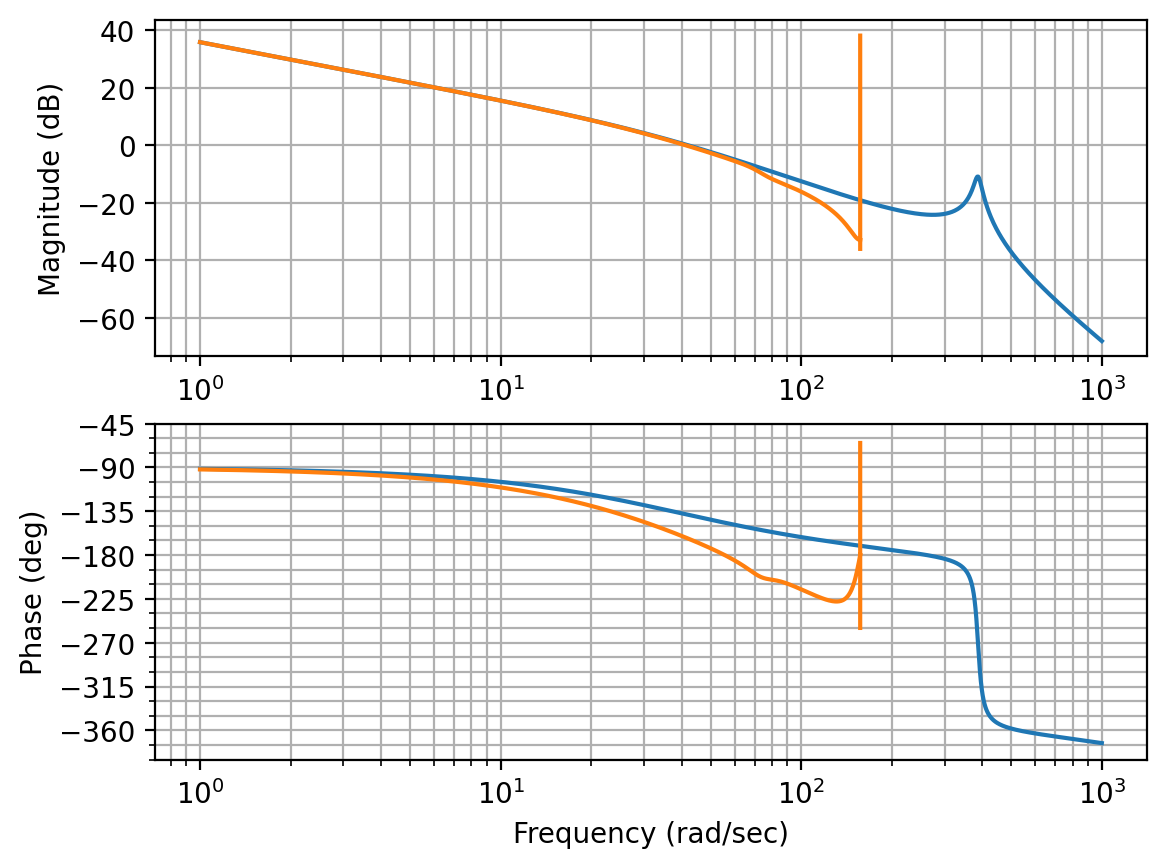

In [109]:
C = np.array([[0, 0, 1, 0, 0, 0], [0, 0, 0, 0, 1, 0]])
D = 0
plantcont = ctm.ss(A, B, C, D, inputs=['e1', 'e2'], outputs=['theta1', 'theta2'])

Ts = 0.02
ny_freq = np.pi/Ts-1e-12
plant = ctm.c2d(plantcont, Ts, 'zoh')

ctm.bode(plantcont[1,0], omega_limits=(1, 1e3))
ctm.bode(plant[1,0], omega_limits=(1, ny_freq));

In [2]:
Cz_num = [1, 0.16] 
e =  [0] * (len(Cz_num))
e

[0, 0]

[0.66702631]


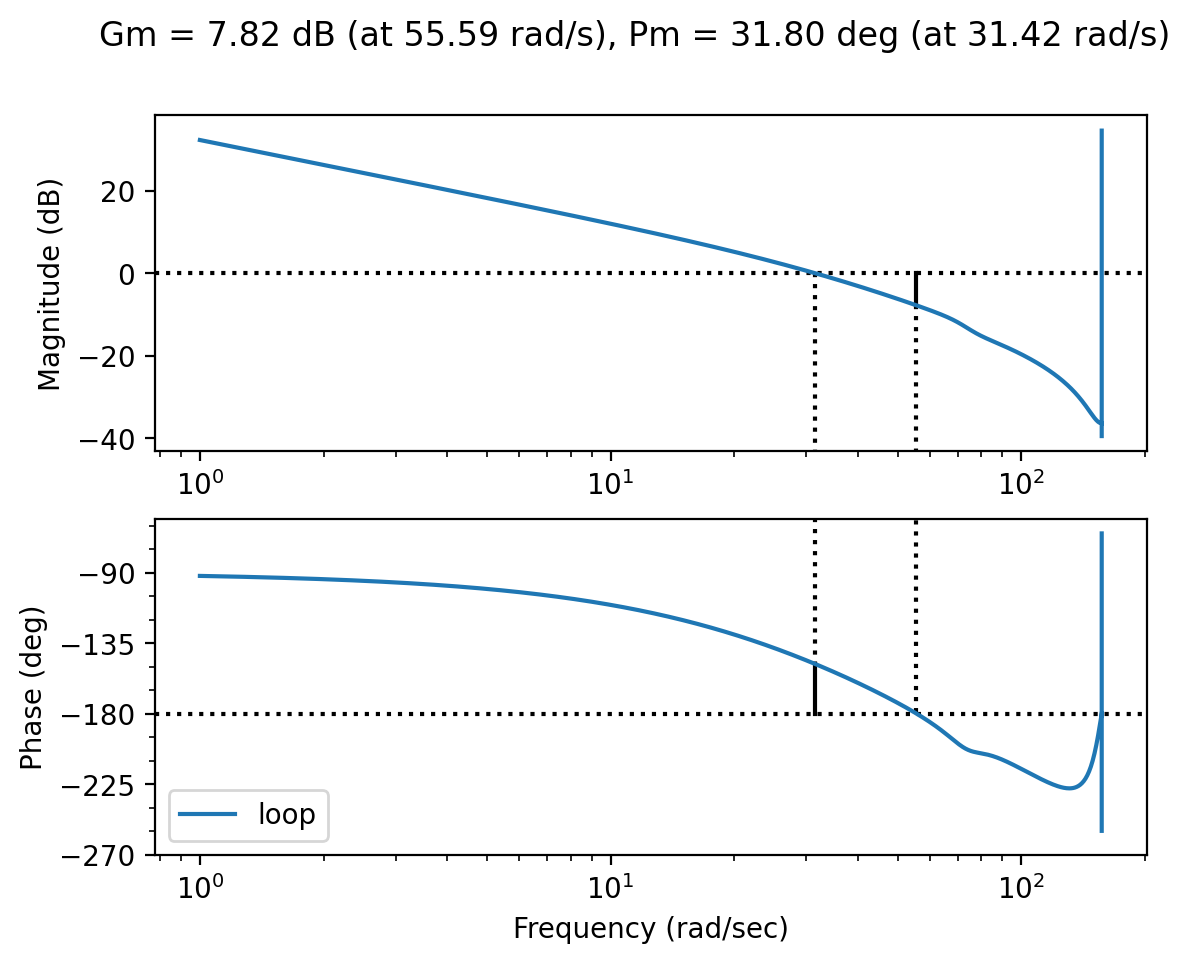

In [110]:
# Find a K
mag, phase, omega = ctm.freqresp(plant[1, 0], 10*np.pi)
K = 1 / mag
print(K)
op = K*plant[1, 0]
ctm.bode(op, omega_limits=(1, ny_freq), label='loop', margins=True);
plt.legend();

In [111]:
pm = 61-31.8
peakphase = np.pi * pm/180

wm = 10*np.pi
wz = wm / np.sqrt((1 + np.sin(peakphase)) / (1 - np.sin(peakphase)))
wp = wm**2 / wz
print(wz, wp)

18.43161462348291 53.54715038646114


- Seems 0dB at $ \omega_m = 10 \pi $ rad/s
- PM = 31.70, hence PM deficit $ \phi_m = 61 - 31.8 = 29.2 $ degrees

Two equations two unknowns
- $ \omega_m = \sqrt{ \omega_z \omega_p} $

- $ sin( \phi_m ) = \frac{\frac{\omega_z}{\omega_p}-1}{\frac{\omega_z}{\omega_p}+1} $

Hence,
- $ \omega_z \approx 53.5472 $
- $ \omega_p \approx 18.4316 $

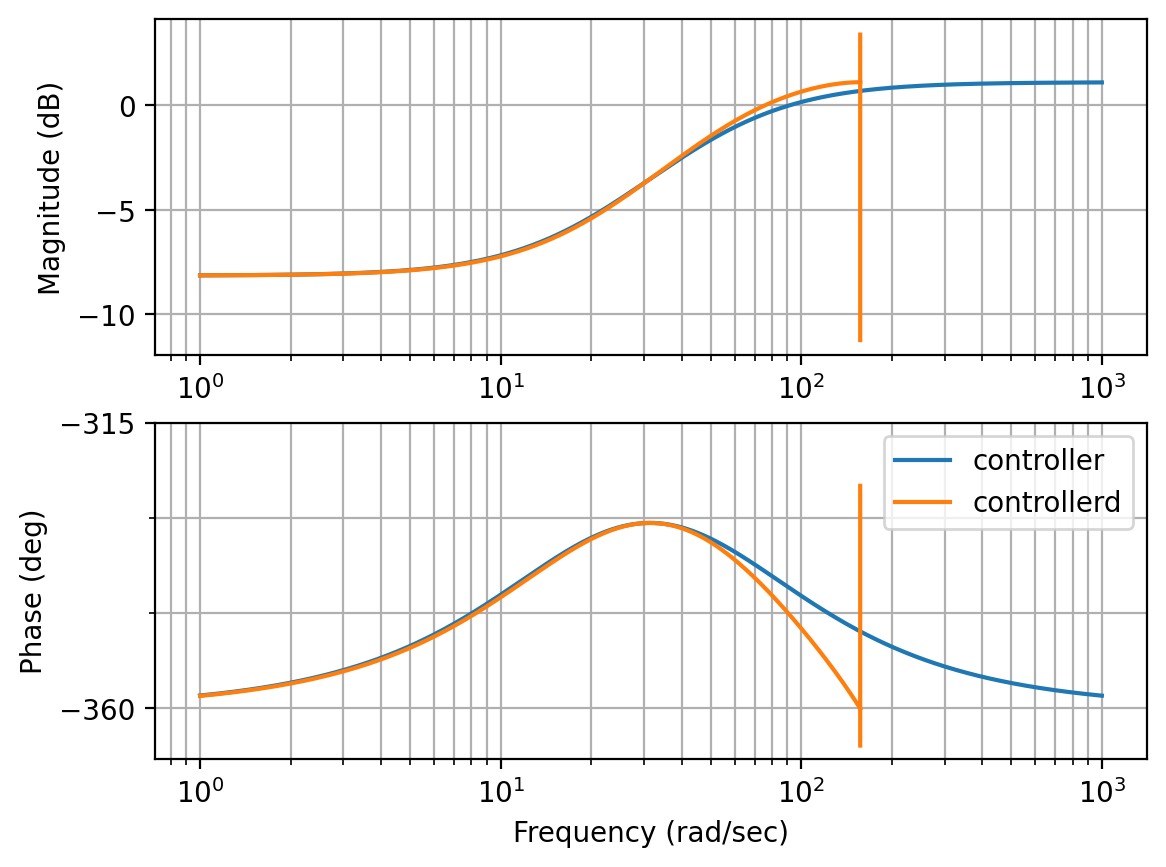

In [112]:

controller = ctm.tf(K * np.sqrt(wp / wz) * ctm.tf([1, wz], [1, wp]))
controllerd = ctm.c2d(controller, Ts, 'bilinear', prewarp_frequency=wm)
ctm.bode(controller,  omega_limits=(1, 1e3), label='controller')
ctm.bode(controllerd,  omega_limits=(1, ny_freq), label='controllerd')
plt.legend()

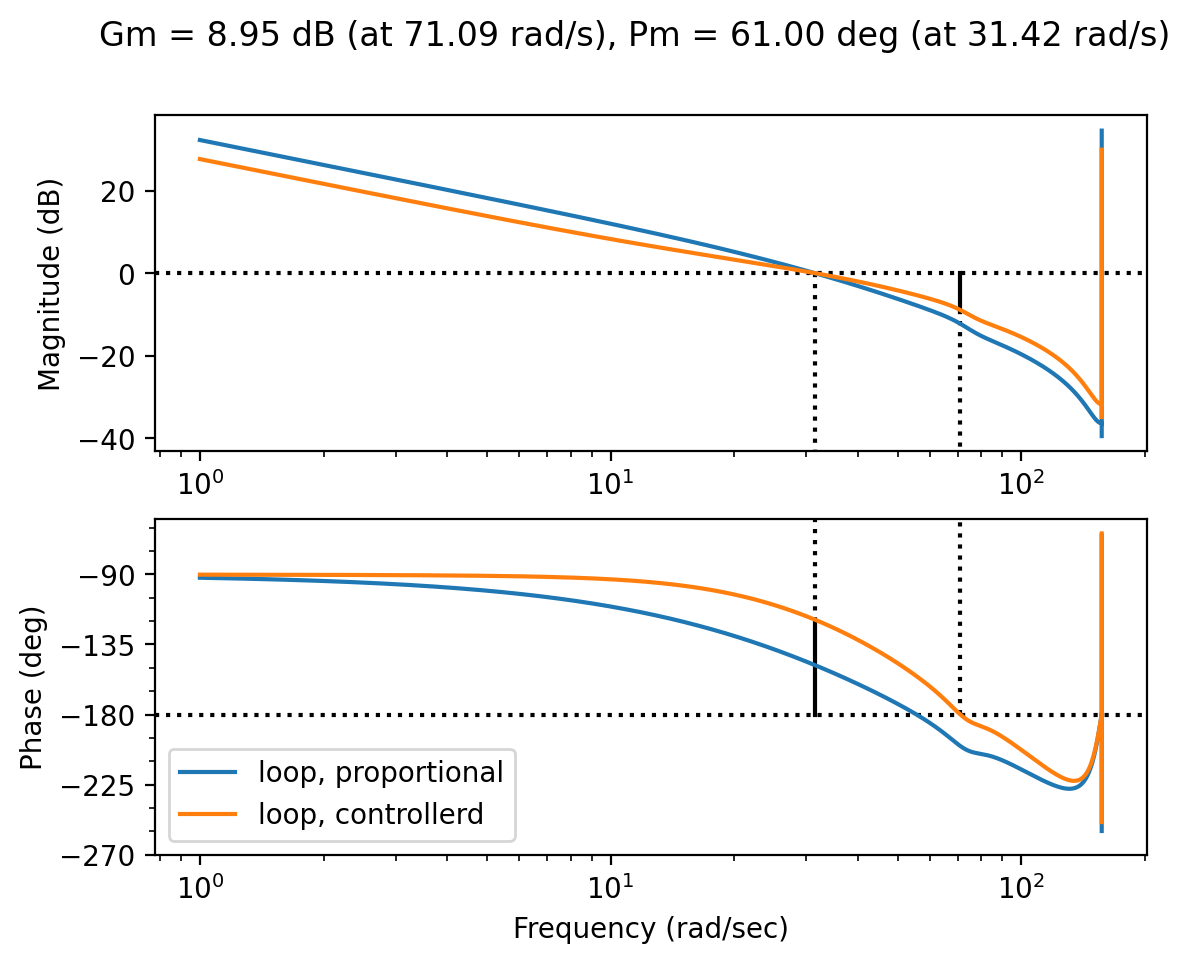

In [113]:
plt.figure()
op2 = controllerd * plant[1,0]
ctm.bode(op, omega_limits=(1, ny_freq), label='loop, proportional')
ctm.bode(op2, omega_limits=(1, ny_freq), label='loop, controllerd', margins=True)
plt.legend();

c:\Users\YENPANG_HUANG\AppData\Local\Programs\Python\Python311\Lib\site-packages\control\iosys.py:1503: UserWarning: Unused input(s) in InterconnectedSystem: (0, 1)=sys[444]$sampled.e2
  warn(msg)
c:\Users\YENPANG_HUANG\AppData\Local\Programs\Python\Python311\Lib\site-packages\control\iosys.py:1509: UserWarning: Unused output(s) in InterconnectedSystem: (0, 0) : sys[444]$sampled.theta1
  warn(msg)
c:\Users\YENPANG_HUANG\AppData\Local\Programs\Python\Python311\Lib\site-packages\control\iosys.py:1503: UserWarning: Unused input(s) in InterconnectedSystem: (2, 0)=sys[467].r
  warn(msg)


array([0.53265892])

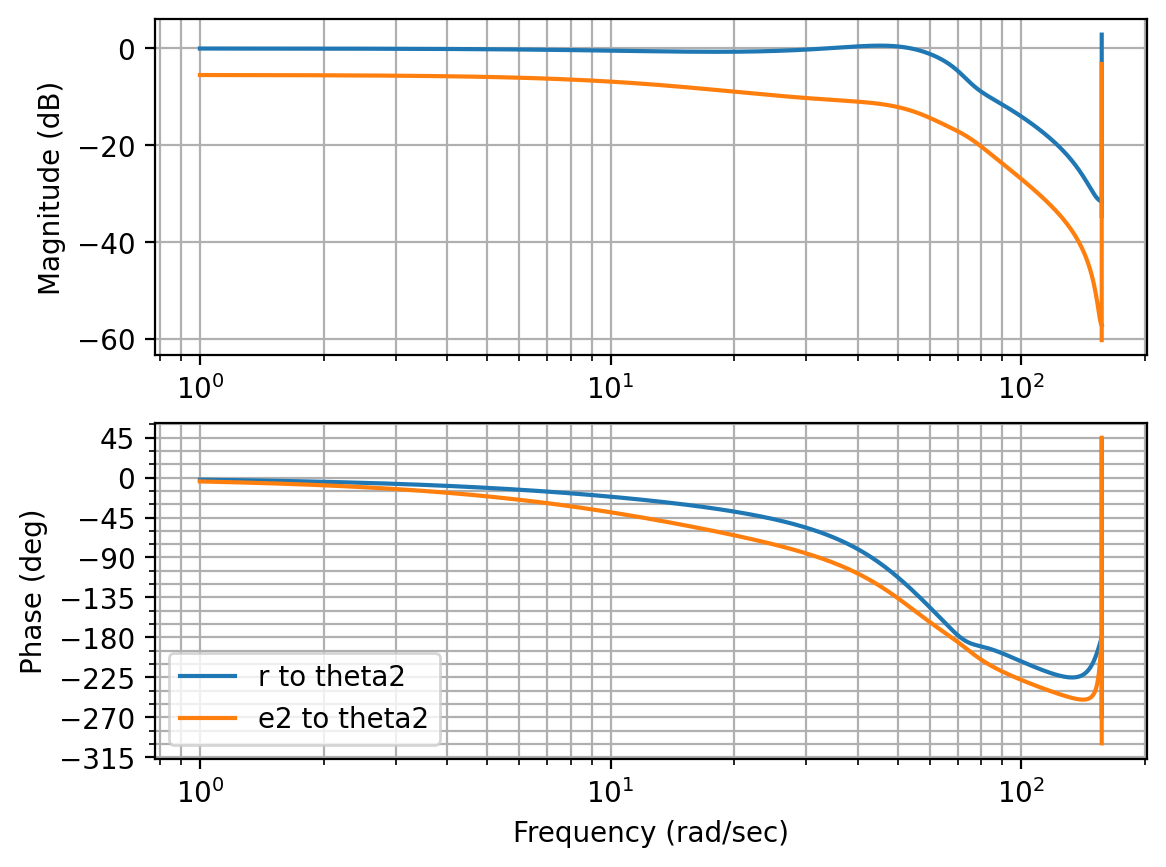

In [114]:
controllerd = ctm.tf(controllerd, inputs='e', outputs='e1')
sum = ct.summing_junction(['r', '-theta2'], 'e')
Gyr = ct.interconnect((plant, controllerd, sum), inputs='r', outputs='theta2')
Gyd = ct.interconnect((plant, controllerd, sum), inputs='e2', outputs='theta2')
ctm.bode(Gyr, omega_limits=(1, ny_freq), label='r to theta2')
ctm.bode(Gyd, omega_limits=(1, ny_freq), label='e2 to theta2')
plt.legend()
ctm.freqresp(Gyd, 0.1)[0]

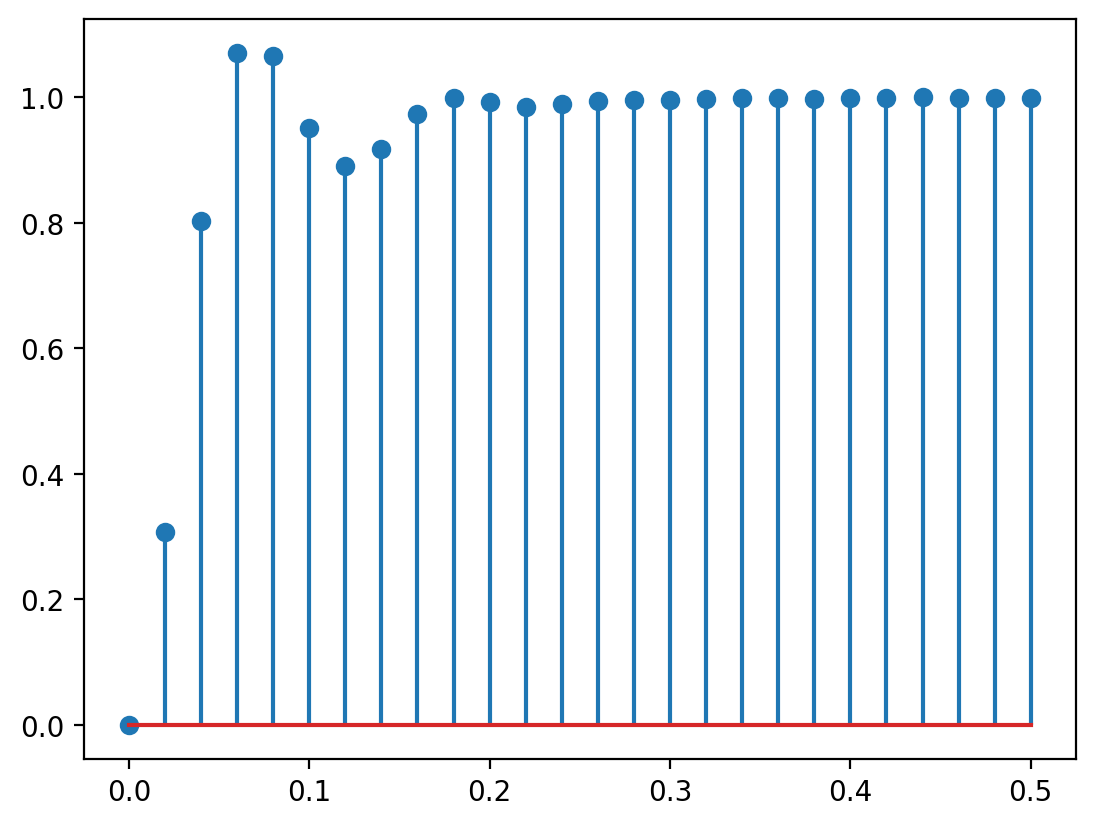

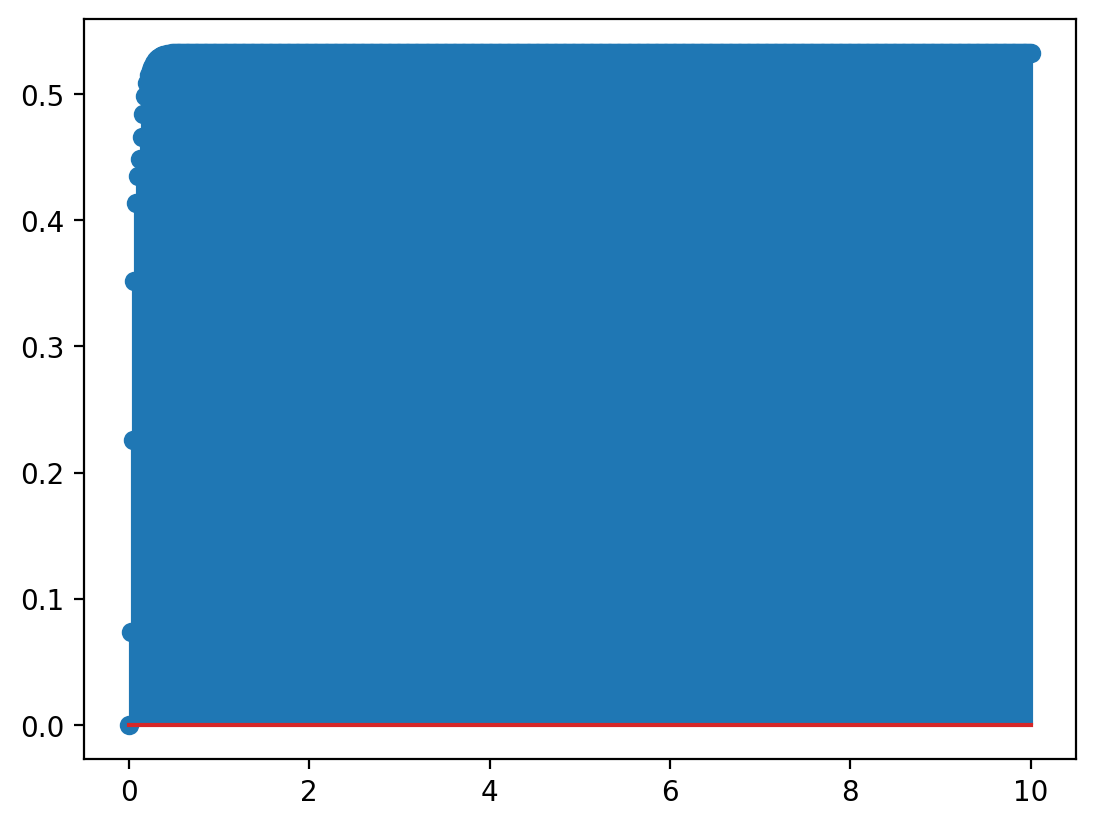

In [115]:
plt.figure()
y, t = ctm.step(Gyr, 0.5)
plt.stem(t, y)
plt.figure()
y, t = ctm.step(Gyd, 10)
plt.stem(t, y);

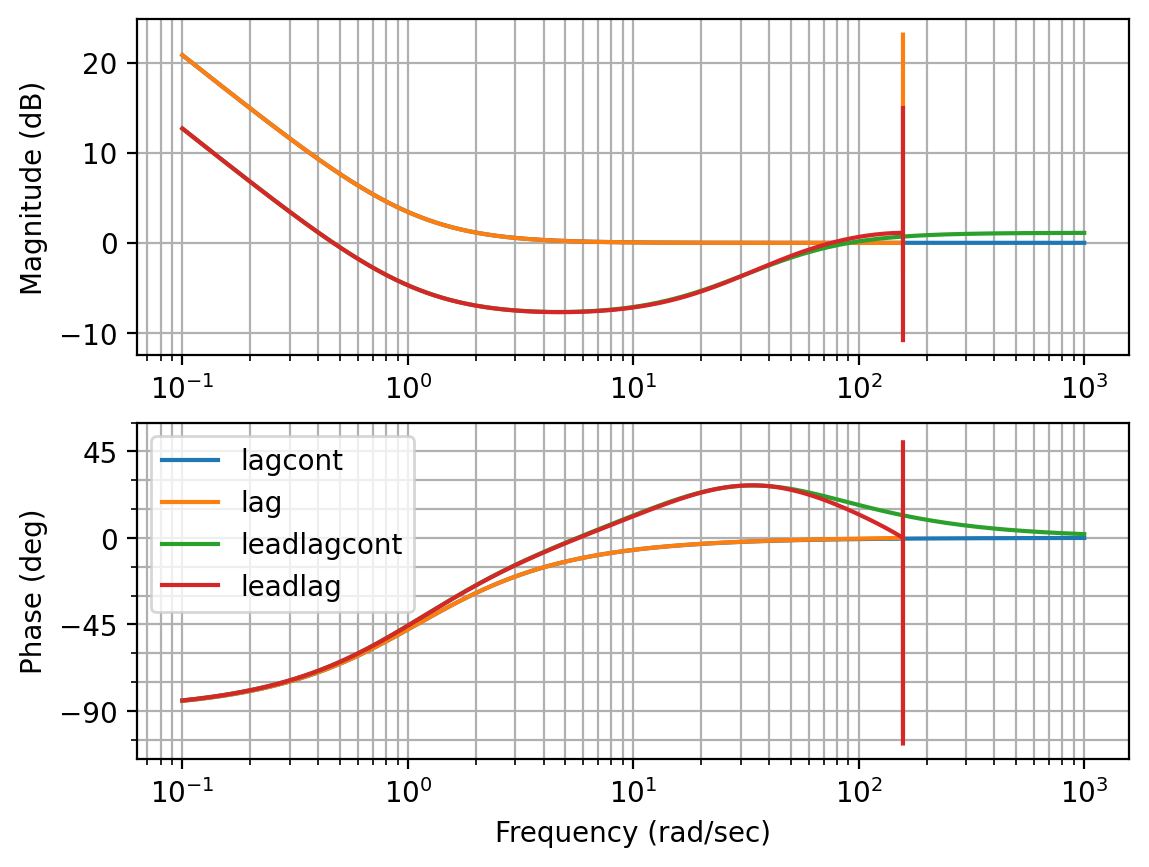

In [116]:
wz_lag = -10*np.pi / np.tan(np.deg2rad(92))
dcgain = 1
if dcgain == 1: 
    wp_lag = 0
else:
    dcgain = 10
    wp_lag = wz_lag/dcgain
lagcont = ctm.tf([1, wz_lag], [1, wp_lag])
lag = ctm.c2d(lagcont, Ts , 'tustin', prewarp_frequency=wm)
lag_crossgain = ctm.freqresp(lag, wm)[0]
lag = lag/lag_crossgain
leadlag = controllerd * lag
leadlagcont = controller * lagcont
ctm.bode(lagcont,  omega_limits=(0.1, 1e3), label='lagcont')
ctm.bode(lag,  omega_limits=(0.1, ny_freq), label='lag')
ctm.bode(leadlagcont,  omega_limits=(0.1, 1e3), label='leadlagcont')
ctm.bode(leadlag,  omega_limits=(0.1, ny_freq), label='leadlag')
plt.legend()

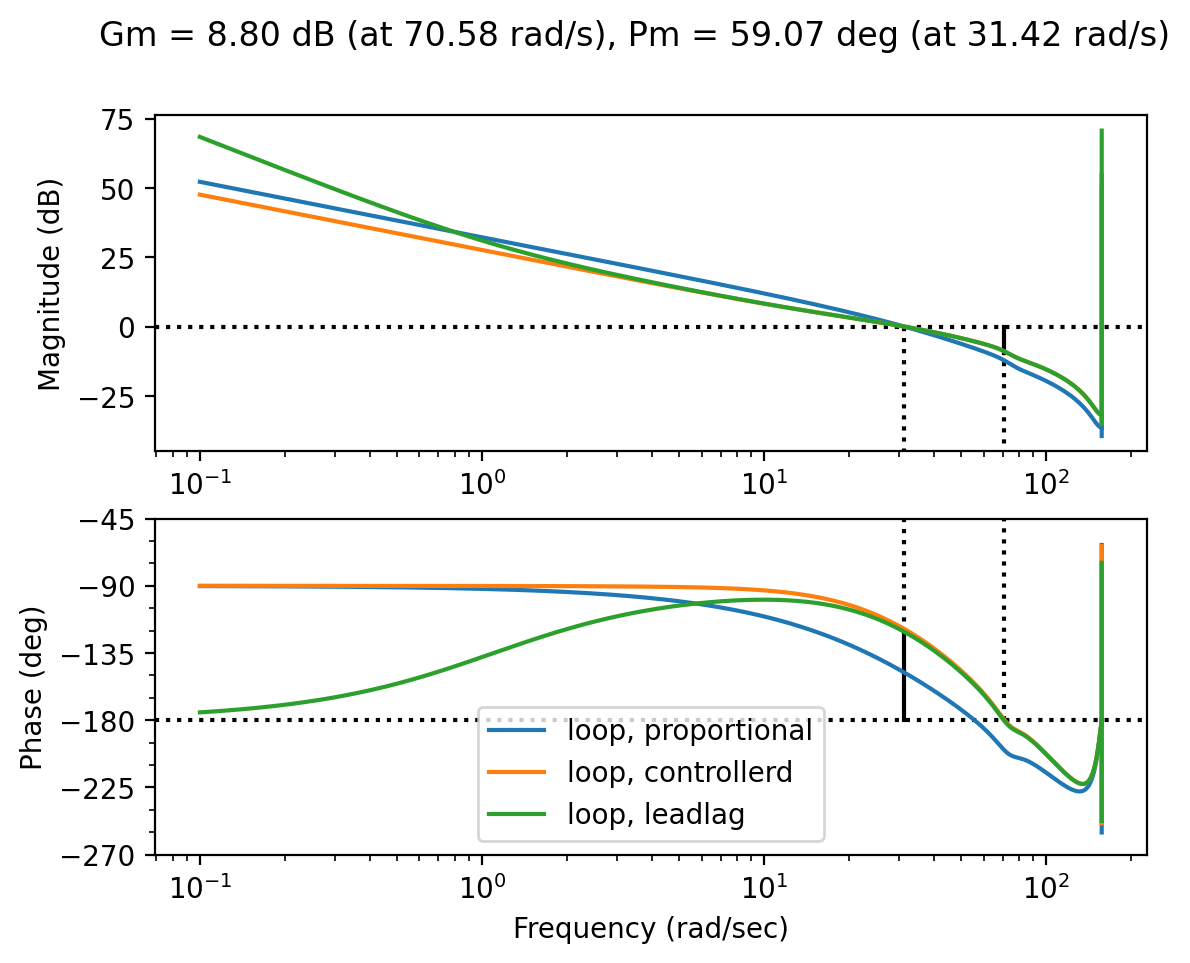

In [117]:
plt.figure()
op3 = leadlag*plant[1, 0]
ctm.bode(op, omega_limits=(0.1, ny_freq), label='loop, proportional')
ctm.bode(op2, omega_limits=(0.1, ny_freq), label='loop, controllerd')
ctm.bode(op3, omega_limits=(0.1, ny_freq), label='loop, leadlag', margins=True)
plt.legend();

With lead-lag compensator design

c:\Users\YENPANG_HUANG\AppData\Local\Programs\Python\Python311\Lib\site-packages\control\iosys.py:1503: UserWarning: Unused input(s) in InterconnectedSystem: (2, 0)=sys[492].r
  warn(msg)


[0.04839862]


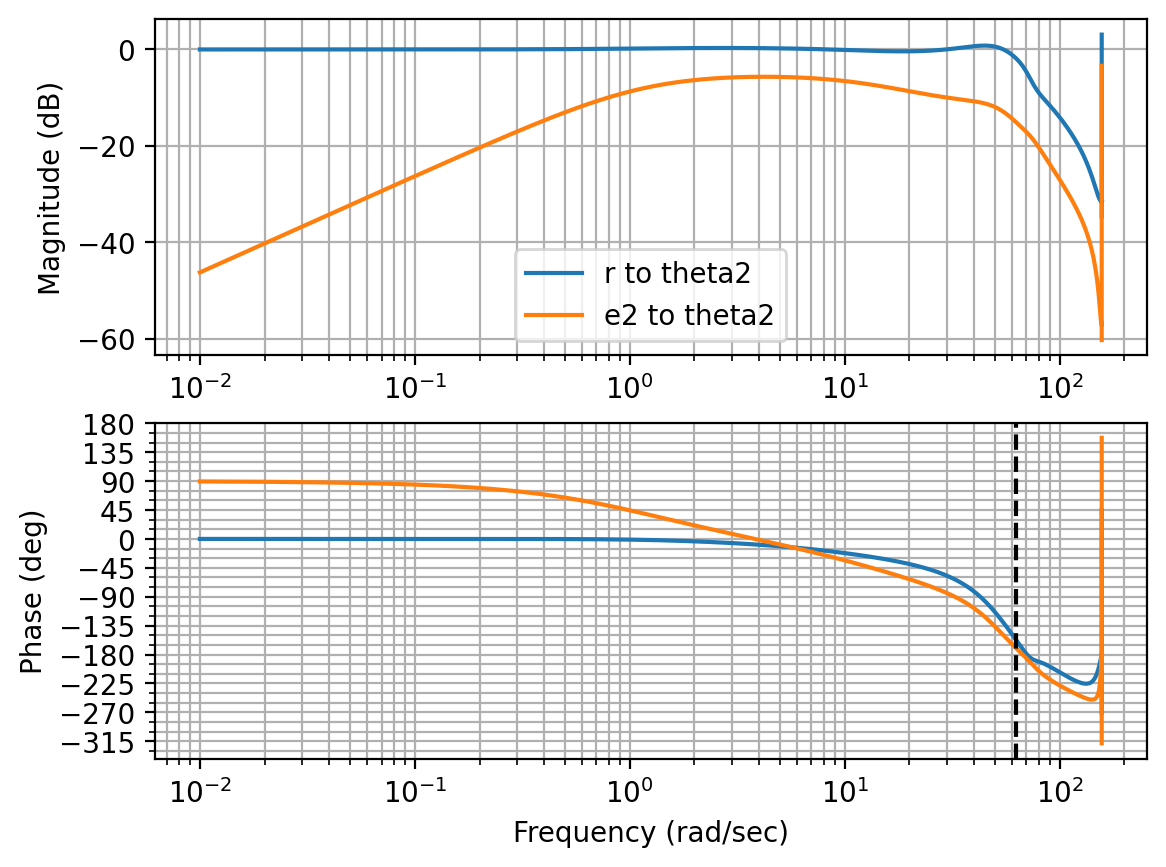

In [118]:
controllerd = ctm.tf(leadlag, inputs='e', outputs='e1')
sum = ct.summing_junction(['r', '-theta2'], 'e')
Gyr = ct.interconnect((plant, controllerd, sum), inputs='r', outputs='theta2')
Gyd = ct.interconnect((plant, controllerd, sum), inputs='e2', outputs='theta2')
ctm.bode(Gyr, omega_limits=(0.01, ny_freq), label='r to theta2')
ctm.bode(Gyd, omega_limits=(0.01, ny_freq), label='e2 to theta2', initial_phase=0)
plt.axvline(20 * np.pi, color='k', linestyle='--')
plt.sca(plt.gcf().get_axes()[0])
plt.legend()
print(ctm.freqresp(Gyd, 0.1)[0])

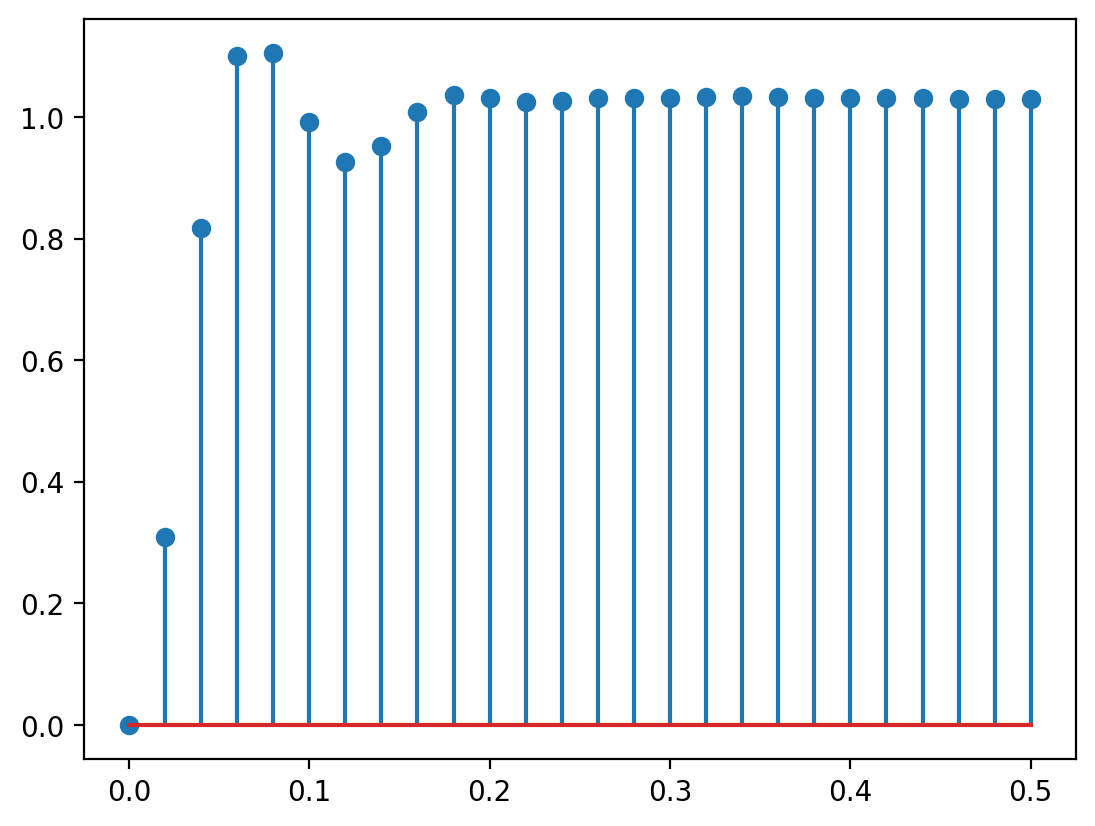

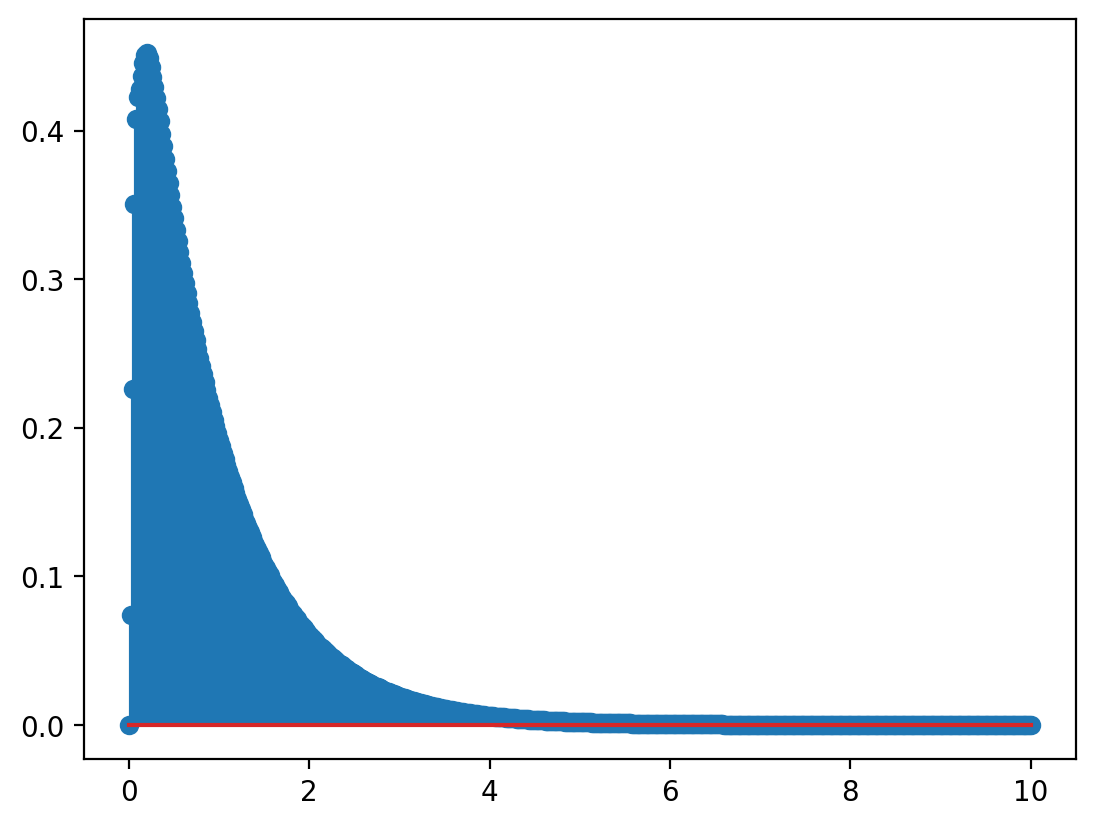

In [119]:
plt.figure()
y, t = ctm.step(Gyr, 0.5)
plt.stem(t, y)
plt.figure()
y, t = ctm.step(Gyd, 10)
plt.stem(t, y);

a. Tracking bandwith is closed to 20 $\pi$ rad/sec.

b. Satisfied with $ \omega_p = 0 $ at dcgain = 1.

c. 0.04839862 which is less than 0.1 rad/sec.

d. Based on the bode plot above, the phase margin is 59.07 which is about 60 degrees.